In [1]:
import numpy as np
import pandas as pd
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import math
import operator
import copy
import json
import plotly.express as px
import plotly.io as pio
import statistics
np.set_printoptions(precision=1,suppress=True)
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'jpg'
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

In [2]:
from scipy.stats import t as student
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
random.seed(42)
np.random.seed(42)

In [3]:
dfBeers = pd.read_csv('data/beers.csv')
dfBrewers = pd.read_csv('data/breweries.csv')

dfBeers = dfBeers.rename(columns={'Unnamed: 0' : 'rowNum'})
dfBrewers = dfBrewers.rename(columns={'Unnamed: 0' : 'brewery_id'})

#striping whitespaces
dfBeers['name'] = dfBeers['name'].str.strip()
dfBeers['style'] = dfBeers['style'].str.strip()
dfBrewers['name'] = dfBrewers['name'].str.strip()
dfBrewers['city'] = dfBrewers['city'].str.strip()
dfBrewers['state'] = dfBrewers['state'].str.strip()

dfBeers.info()
dfBrewers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brewery_id  558 non-null    int64 
 1   name        558 non-null    object
 2   city        558 non-null    object
 3   state       558 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.6+ KB


Before we analyze and use the data we have to account for the missing values.

Since there are few missing alcohol level(**abv**) and **style** values, we'll impute them using simpler methods, and then perform a visual analysis of the data. Afterwards we will impute the missing **ibu** using a more complex approach since a very large portion of the data is missing.

For the missing **abv** values, we will use a **hot deck** imputation method, where we replace the missing value with the median alcohol level of beers of the same **style**. This method seems most intuative since it is common for beers of the same style to have similar alcohol levels.

In [4]:
#fixing missing alcohol levels

#seperate beers that have abv and ones that don't
notValid = dfBeers[dfBeers['abv'].isna()]
valid = dfBeers[dfBeers['abv'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    sameStyle = valid['style'] == notValid['style'][ind] #filter to find beers from same style
    newValue = (valid[sameStyle]['abv']).median() # make missing values equal to median of same style beers(hot deck method)
    
    #incase there are no other valid beers from same style, make value equal to median of whole dataset
    if math.isnan(newValue):
        newValue = valid['abv'].median()
    
    dfBeers.loc[filter,'abv'] = newValue

In [5]:
dfBeers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2410 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


For the missing styles, since we are only missing 5 values, we will just use the simplest method, which is replacing the missing values with the **mode** of all styles.

In [6]:
#fixing missing styles
#we make missing styles equal to most common style(mode) from whole dataset

#seperate beers that have style and ones that don't
notValid = dfBeers[dfBeers['style'].isna()]
valid = dfBeers[dfBeers['style'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    dfBeers.loc[filter,'style'] = dfBeers['style'].mode()[0]

In [7]:
dfBeers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2410 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2410 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


## Visualizations

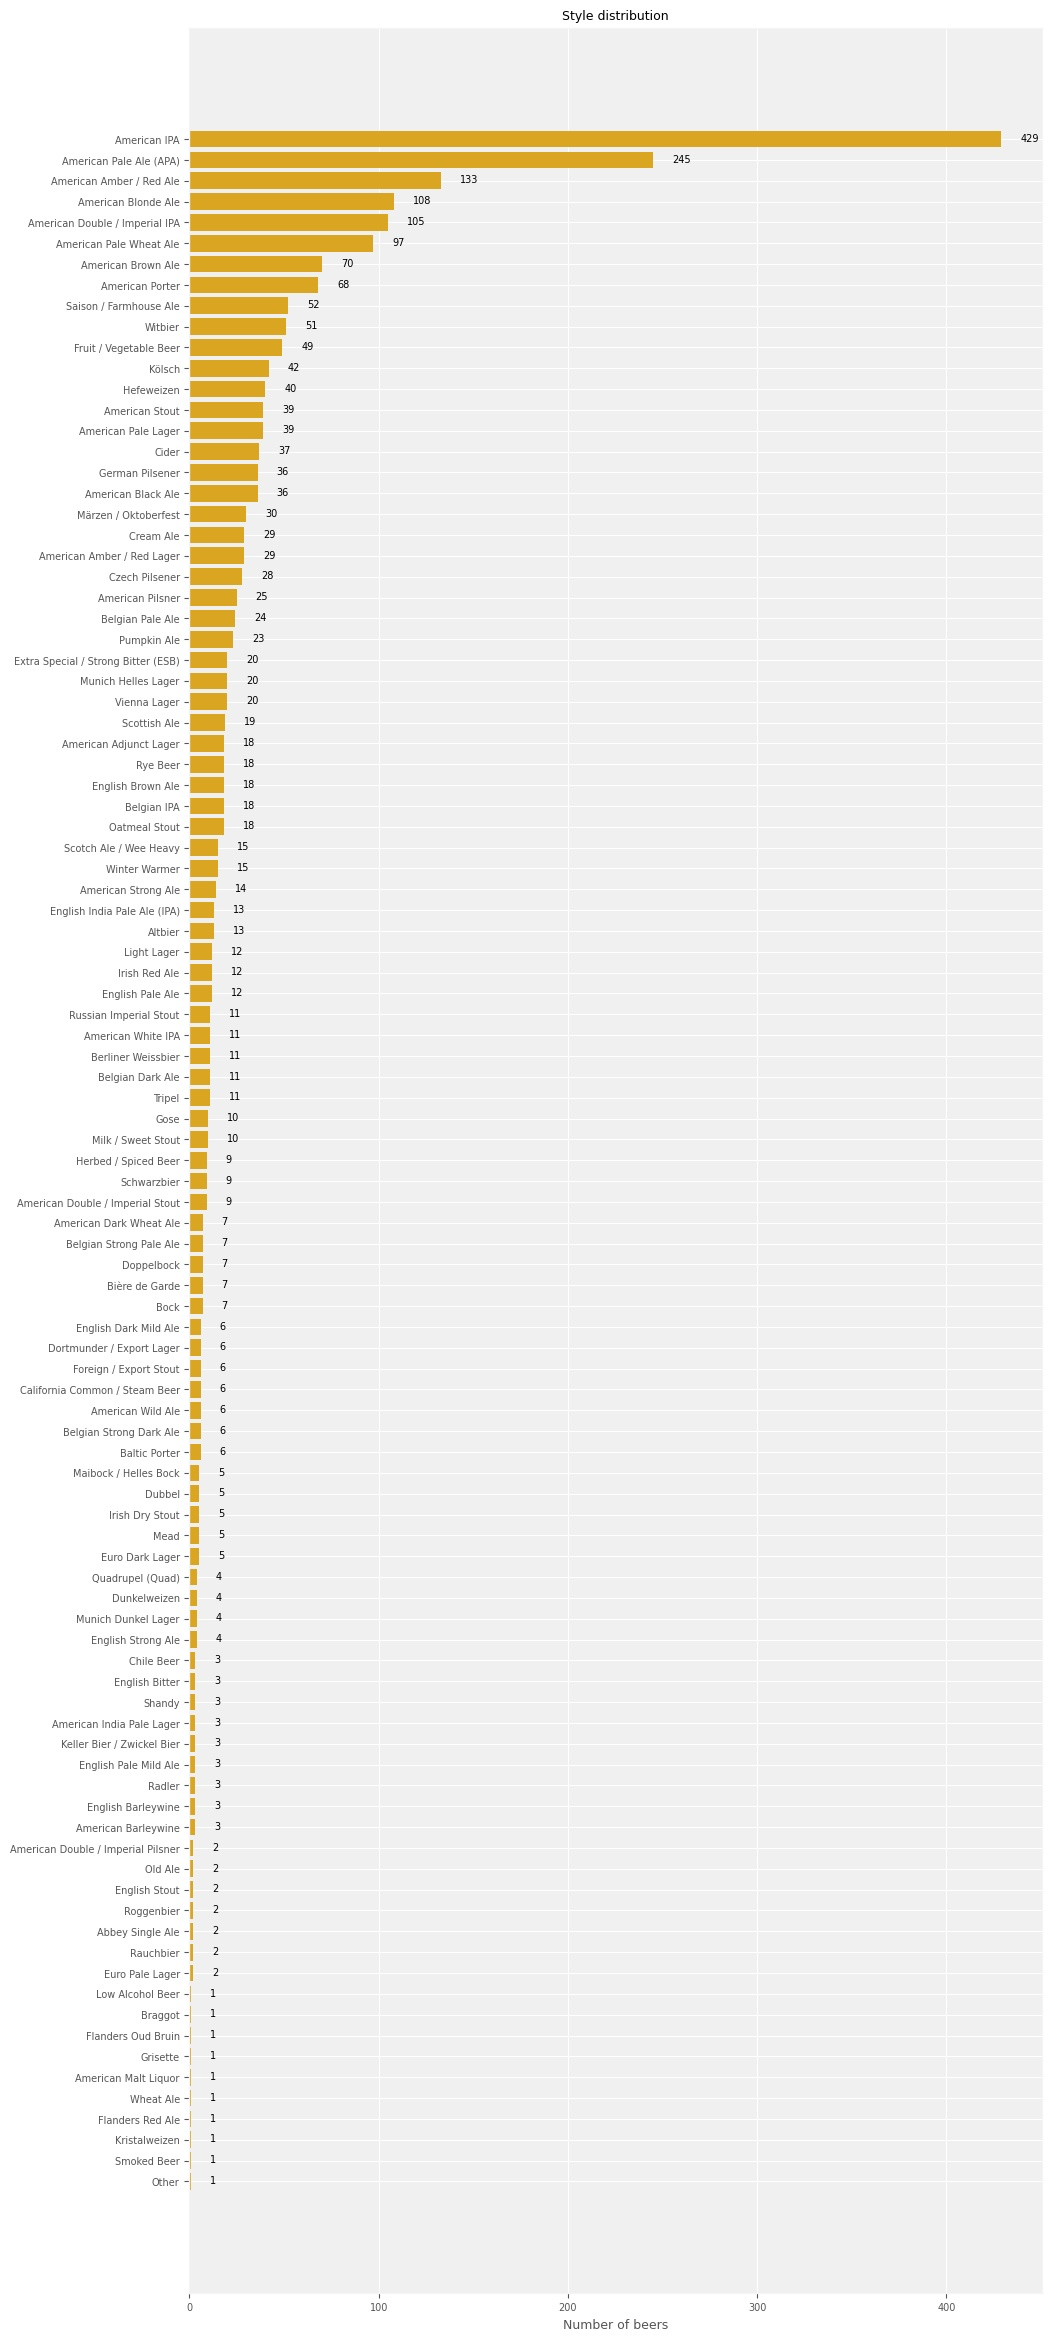

In [8]:
#checking style distributions

styleDict = {}

for ind in dfBeers.index:
    temp = dfBeers['style'][ind]
    if temp not in styleDict:
        styleDict[temp] = 1
    else:
        styleDict[temp] += 1

styles_sorted  = sorted(styleDict.keys(), key=lambda x: styleDict[x])
x = [styleDict[style] for style in styles_sorted]
y = range(len(styles_sorted))
plt.figure(figsize=(11, 30));
plt.barh(y, x, color='goldenrod')
plt.yticks(y);
plt.gca().set_yticklabels(styles_sorted)
#plt.ylim(-0.5, len(styles_sorted)-0.5)
plt.xlabel("Number of beers");
for i in y:
    plt.text(10 + x[i], i-0.1, 
             f"{x[i]}");
plt.title("Style distribution");


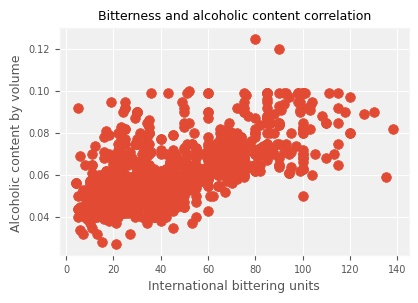

In [9]:
plt.scatter(dfBeers.ibu, dfBeers.abv)
plt.xlabel("International bittering units")
plt.ylabel("Alcoholic content by volume ")
plt.title("Bitterness and alcoholic content correlation");

In [10]:
def pearson(x, y):
    return np.mean(((x - np.mean(x))*(y-np.mean(y)))/(np.std(x)*np.std(y)))

In [11]:
pearson(dfBeers.ibu, dfBeers.abv)

0.6769756239271906

Pearson shows a good positive correlation

In [12]:
top_ten_styles = set(styles_sorted[-10:])

top_beers_df = dfBeers[dfBeers['style'].isin(top_ten_styles)]
bit = []
for bitterness in top_beers_df['ibu']:
    if np.isnan(bitterness):
        bit.append(np.nan)
    elif bitterness <= 50:
        bit.append('Low')
    elif bitterness <= 94:
        bit.append('Medium')
    else:
        bit.append('High')

top_beers_df.insert(len(top_beers_df.columns), "Bitterness", bit, True)
#df.loc[df.Weight == "155", "Name"] = "John"
top_beers_df

,rowNum,abv,ibu,id,name,style,brewery_id,ounces,Bitterness
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0,NaN
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0,NaN
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0,NaN
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0,NaN
6,6,0.045,NaN,2260,Lake Street Express,American Pale Ale (APA),177,12.0,NaN
...,...,...,...,...,...,...,...,...,...
2399,2399,0.069,69.0,1512,Worthy IPA (2013),American IPA,199,12.0,Medium
2400,2400,0.060,50.0,1511,Worthy Pale,American Pale Ale (APA),199,12.0,Low
2406,2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0,NaN
2408,2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0,Low


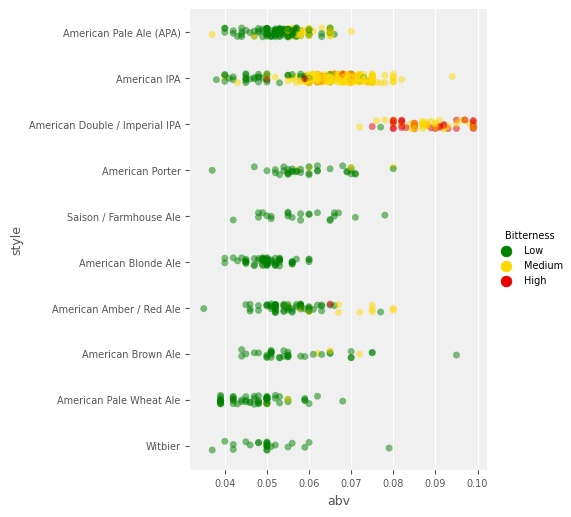

In [13]:
ax = sns.catplot(y="style", x="abv", jitter=True, data=top_beers_df, hue="Bitterness", 
                 palette=[(0, 0.5, 0), (1, 0.85, 0), (0.9, 0, 0)], legend=True, 
                 hue_order= ["Low", "Medium", "High"], alpha=0.5);

In [14]:
#Distributions for bitterness and alcohol levels of each beer

bitterness = []
alcoholLevels = []
for name in set(dfBeers["name"]):
    ibu = [x for x in dfBeers["ibu"][dfBeers["name"]==name] if np.isnan(x)==False]
    abv = [x for x in dfBeers["abv"][dfBeers["name"]==name] if np.isnan(x)==False]
    if (len(ibu)>0):
        bitterness.append(np.mean(ibu))
    if (len(abv)>0):
        alcoholLevels.append(np.mean(abv))

In [15]:
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

def betaDistribution(a, b, samples, labels):
    for i in range(len(samples)):
        sample = samples[i]
        xr = np.linspace(0, np.max(sample), 100)     
        parameters_Beta = beta.fit(sample)
        P_fit_Beta = [beta.pdf(x, *parameters_Beta) for x in xr]
        if (i%2==0):
            plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, int(i%2)+1)
        plt.hist(sample,    label="Sample", density=True)
        plt.plot(xr, P_fit_Beta, label="Model", linewidth=2.0)
        plt.title("Beta distribution for "+labels[i])
        plt.legend()
        if ((i-1)%2==0 and i>0):
            plt.show()
    plt.show()

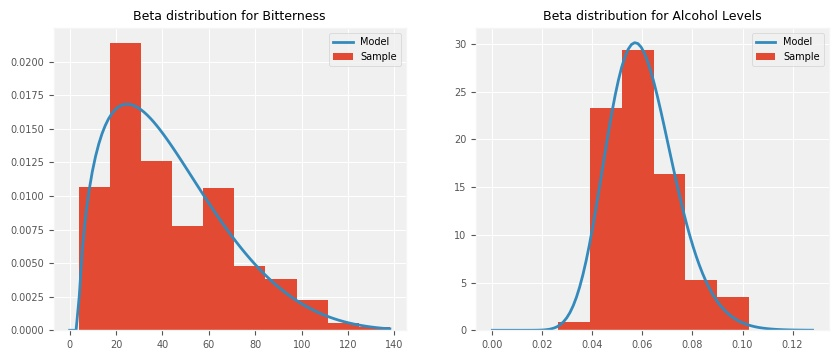

In [16]:
betaDistribution(0, 1, [bitterness, alcoholLevels], ["Bitterness", "Alcohol Levels"])

In [17]:
states = sorted(list(set(dfBrewers["state"])))
states_dict = dict.fromkeys(states)
beer_styles = set(dfBeers["style"])
for key in states_dict:
    states_dict[key] = dict.fromkeys(beer_styles, 0)

In [18]:
for state in states_dict:
    state_boolean = np.array(dfBeers['brewery_id'].isin(dfBrewers[dfBrewers['state'] == state].brewery_id))
    for style in states_dict[state]:
        style_boolean = np.array(dfBeers['style'] == style)
        states_dict[state][style] = sum(np.logical_and(state_boolean, style_boolean))

In [19]:
state_most_pop_style = dict()
for key in states_dict:
    state_most_pop_style[key] = sorted(states_dict[key].items(), key=lambda x: x[1])[-1][0]
state_most_pop_style = state_most_pop_style.items()

In [20]:
state_abv = dict()
state_ibu = dict()
for state in states_dict:
    state_abv[state] = round(np.mean(dfBeers[dfBeers["brewery_id"].isin(dfBrewers[
        dfBrewers['state'] == state].brewery_id)].abv), 3)
    state_ibu[state] = round(np.mean(dfBeers[dfBeers["brewery_id"].isin(dfBrewers[
        dfBrewers['state'] == state].brewery_id)].ibu), 3)

In [21]:
states_styles_df = pd.DataFrame(state_most_pop_style, columns=["State", "Style"])
usa_map = json.load(open("data/us-states.json", 'r', encoding="utf-8"))

In [22]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
us_state_abbrev = {value: key for key, value in us_state_abbrev.items()}

In [23]:
state_id_map = dict()
for features in usa_map["features"]:
    state_id_map[features["properties"]["name"]] = features["id"]
states_styles_df["id"] = states_styles_df["State"].apply(lambda x : state_id_map[us_state_abbrev[x]])
states_styles_df["Full state name"] = states_styles_df["State"].apply(lambda x : us_state_abbrev[x])
states_styles_df["abv"] = states_styles_df["State"].apply(lambda x : state_abv[x])
states_styles_df["ibu"] = states_styles_df["State"].apply(lambda x : state_ibu[x])

In [24]:
states_styles_df.head()

,State,Style,id,Full state name,abv,ibu
0,AK,American IPA,02,Alaska,0.056,40.882
1,AL,American IPA,01,Alabama,0.062,51.222
2,AR,American Amber / Red Ale,05,Arkansas,0.052,39.000
3,AZ,American IPA,04,Arizona,0.060,35.208
4,CA,American IPA,06,California,0.061,46.281


In [25]:
"""
pio.renderers.default = "browser"
fig = px.choropleth(states_styles_df, 
                    locations="id", 
                    geojson=usa_map, 
                    color="Style", 
                    scope="usa",
                    hover_name="Full state name",
                    hover_data=["Style", "ibu", "abv"])
fig.show()
"""

'\npio.renderers.default = "browser"\nfig = px.choropleth(states_styles_df, \n                    locations="id", \n                    geojson=usa_map, \n                    color="Style", \n                    scope="usa",\n                    hover_name="Full state name",\n                    hover_data=["Style", "ibu", "abv"])\nfig.show()\n'

In [26]:
states_styles_df.head()

,State,Style,id,Full state name,abv,ibu
0,AK,American IPA,02,Alaska,0.056,40.882
1,AL,American IPA,01,Alabama,0.062,51.222
2,AR,American Amber / Red Ale,05,Arkansas,0.052,39.000
3,AZ,American IPA,04,Arizona,0.060,35.208
4,CA,American IPA,06,California,0.061,46.281


In [27]:
'''import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc

import dash_html_components as html
from dash.dependencies import Input, Output
# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H3("Stats by state"),
    dcc.Graph(id='graph'),
    html.Label([
        "Attribute",
        dcc.Dropdown(
            id='selected_attr_dropdown', clearable=False,
            value='Style', options=[
                {'label': c, 'value': c}
                for c in ["Style", "abv", "ibu"]
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("selected_attr_dropdown", "value")]
)
def update_figure(selected_attr):
    return px.choropleth(states_styles_df, 
                        locations="id", 
                        geojson=usa_map, 
                        color=selected_attr, 
                        scope="usa",
                        hover_name="Full state name",
                        hover_data=["Style", "ibu", "abv"])
# Run app and display result inline in the notebook
app.run_server(mode='inline')'''

'import plotly.express as px\nfrom jupyter_dash import JupyterDash\nimport dash_core_components as dcc\n\nimport dash_html_components as html\nfrom dash.dependencies import Input, Output\n# Load Data\ndf = px.data.tips()\n# Build App\napp = JupyterDash(__name__)\napp.layout = html.Div([\n    html.H3("Stats by state"),\n    dcc.Graph(id=\'graph\'),\n    html.Label([\n        "Attribute",\n        dcc.Dropdown(\n            id=\'selected_attr_dropdown\', clearable=False,\n            value=\'Style\', options=[\n                {\'label\': c, \'value\': c}\n                for c in ["Style", "abv", "ibu"]\n            ])\n    ]),\n])\n# Define callback to update graph\n@app.callback(\n    Output(\'graph\', \'figure\'),\n    [Input("selected_attr_dropdown", "value")]\n)\ndef update_figure(selected_attr):\n    return px.choropleth(states_styles_df, \n                        locations="id", \n                        geojson=usa_map, \n                        color=selected_attr, \n          

## Imputation of data - Bitterness

Because many values from **ibu** are missing we need to use some kind on an imputation. The case of the missing values was not provided in the description, so we assume that the values are most likey *missing completly at random*, or *missing at random*. In this case we try to model the *bitterness units* (**ibu**) with multiple regression models and choose the one that best fits the data, and use it to predict the **NaN** values.

In [28]:
#fixing missing ibu values
#We use multiple imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer

#Create numpy array from dataframe and remove categorical data
arrBeers = dfBeers.to_numpy()
arrBeers = np.delete(arrBeers, 4, 1)
#arrBeers = np.delete(arrBeers, 4, 1)

print(arrBeers[:,5])

#arrBeers = imp.fit_transform(arrBeers)

[408 177 177 ... 424 424 424]


In [29]:
encoder = OneHotEncoder(handle_unknown='ignore')
styles_np = arrBeers[:,[4]]
encoder_fit = encoder.fit(styles_np)
styles_encoded = encoder.transform(styles_np).toarray()

from categorical to boolean vecors (algorithms do not work with nominal and categorical values).

In [30]:
brew_id = arrBeers[:, [5]]
encoder = OneHotEncoder(handle_unknown='ignore').fit(brew_id)
brew_id_transformed = encoder.transform(brew_id).toarray()

In [31]:
brew_id_transformed.shape, len(set(dfBeers['brewery_id']))

((2410, 558), 558)

In [32]:
arrBeers = np.delete(arrBeers, 4, 1)
arrBeers = np.delete(arrBeers, 0, 1)
arrBeers = np.delete(arrBeers, 2, 1)
arrBeers = np.delete(arrBeers, 2, 1)

deleting the values that are directly connected to the beer (ids, etc).

In [33]:
arrBeers = np.concatenate((arrBeers, styles_encoded), axis=1)
arrBeers = np.concatenate((arrBeers, brew_id_transformed), axis=1)

In [34]:
#arrBeers = imp.fit_transform(arrBeers)
arrBeers = arrBeers.astype('float')
arrBeers_filtered = arrBeers[~np.isnan(arrBeers[:,1]),:]
#train, test = shuffle_and_split(arrBeers_filtered)

In [35]:
def shuffle_and_split(data):
    np.random.seed(42)
    np.random.shuffle(data)
    train, test = data[:round(0.75 * data.shape[0]),:], data[round(0.75 * data.shape[0]):,:]
    return train, test

Data is split in 75% -25% learning, testing set. ** why we chose this ....**

In [36]:
def make_models(data, models):
    from collections import defaultdict
    result = defaultdict(list)
    train, test = shuffle_and_split(data)
    y_train = train[:, 1]
    X_train = np.delete(train, 1, 1)
    
    for model in models:
        results_model = []
        model.fit(X_train, y_train)
        X_test = np.delete(test, 1, 1)
        y_test = test[:, 1]
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        result[model].append((rmse, r2))
    return result

In [37]:
def get_results(data, models):
    from collections import defaultdict
    results = defaultdict(dict)
    for i in range(4):
        results[i] = make_models(data, models)
    return results

The experiments are repeated 4 times....

In [38]:
def mean_from_results(results, models):
    for model in models:
        mean_rmse = []
        mean_r2 = []
        for experiment in range(4):
            r2_score = [r2 for _, r2 in results[experiment][model]]
            rmse = [rmse for rmse, _ in results[experiment][model]]
            mean_rmse.append(np.mean(rmse))
            mean_r2.append(np.mean(r2_score))
        print(f"{str(model):>10} {np.mean(mean_rmse) :>.3f} {np.mean(mean_r2) :>.3f}")

In [39]:
model_basic_lin = LinearRegression()
model_lasso = Lasso(alpha=1)
model_ridge = Ridge(alpha=1)
model_rnd_forest = RandomForestRegressor(random_state=1)
models = [model_basic_lin, model_lasso, model_ridge, model_rnd_forest]

In [40]:
#reg_result = make_models(arrBeers_filtered, models)
results = get_results(arrBeers_filtered, models)
mean_from_results(results, models)

LinearRegression() 1105087392395.956 -1883128119844303273984.000
Lasso(alpha=1) 18.963 0.502
Ridge(alpha=1) 13.930 0.731
RandomForestRegressor(random_state=1) 12.749 0.775


From all the models *Random forest regressor* works the best with $ R^2 $ = 0.789 and ***RMSE*** = 11.760 (average values of four repeated experiments.)

In [41]:
arrBeers_NaN = arrBeers[np.isnan(arrBeers[:,1])]
arrBeers_NaN = np.delete(arrBeers_NaN, 1, 1)
y = arrBeers_filtered[:, 1]
X = np.delete(arrBeers_filtered, 1, 1)
model_rnd_forest.fit(X, y)
predicted_bitterness = model_rnd_forest.predict(arrBeers_NaN)

In [42]:
np.mean(predicted_bitterness)

36.05183113006397

In [43]:
#dfBeers[np.isnan(dfBeers["ibu"])].replace(predicted_bitterness, inplace=True)
dfBeers.loc[np.isnan(dfBeers["ibu"]), "ibu"] = predicted_bitterness

In [44]:
dfBeers

,rowNum,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,21.29,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,60.11,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,68.43,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,87.40,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,77.70,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...,...
2405,2405,0.067,45.00,928,Belgorado,Belgian IPA,424,12.0
2406,2406,0.052,23.04,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,2407,0.055,24.95,620,B3K Black Lager,Schwarzbier,424,12.0
2408,2408,0.055,40.00,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


The dataframe we replaced NaN ibu with predictions from the random forest model.

## Regional grouping

To better gain some insight into any possibly interesting correlations or differences in data, we decided to group the beers into geographical regions based on their respective brewery's state. These regions include the North East, the South East, the Mid West, the South West and the West. 

We will try to distinguish if there is any speciffic difference in taste between regions of the United States, and see which styles are most popular everywhere.

In [45]:
#Grouping states into regions

northEastArr = set(["ME","MA","RI", "CT", "NH", "VT", "NY", "PA", "NJ", "DE", "MD"])
southEastArr = set(["WV","VA", "KY", "TN", "NC", "SC", "GA", "AL", "MS", "AR", "LA", "FL"])
midWestArr = set(["OH", "IN", "MI", "IL", "MS", "WI", "MN", "IA", "KS", "NE", "SD", "ND"])
southWestArr = set(["TX", "OK", "NM", "AZ"])
westArr = set(["CO", "WY", "MT", "ID", "WA", "OR", "UT", "NV", "CA", "AK", "HI"])

northEastBrewers = dfBrewers[dfBrewers['state'].isin(northEastArr)]['brewery_id']
southEastBrewers = dfBrewers[dfBrewers['state'].isin(southEastArr)]['brewery_id']
midWestBrewers = dfBrewers[dfBrewers['state'].isin(midWestArr)]['brewery_id']
southWestBrewers = dfBrewers[dfBrewers['state'].isin(southWestArr)]['brewery_id']
westBrewers = dfBrewers[dfBrewers['state'].isin(westArr)]['brewery_id']

NE_Beers = dfBeers[dfBeers['brewery_id'].isin(northEastBrewers)]
SE_Beers = dfBeers[dfBeers['brewery_id'].isin(southEastBrewers)]
MW_Beers = dfBeers[dfBeers['brewery_id'].isin(midWestBrewers)]
SW_Beers = dfBeers[dfBeers['brewery_id'].isin(southWestBrewers)]
W_Beers = dfBeers[dfBeers['brewery_id'].isin(westBrewers)]

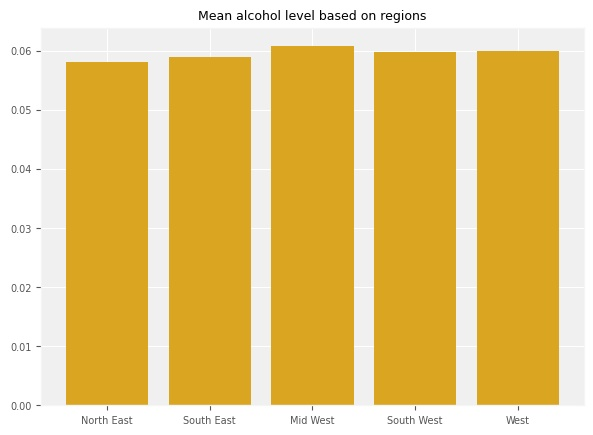

In [46]:
#checking mean alcohol level based on region
xAxis = ['North East', 'South East', 'Mid West', 'South West', 'West']
yAxis = [NE_Beers['abv'].mean(), SE_Beers['abv'].mean(), MW_Beers['abv'].mean(), SW_Beers['abv'].mean(), W_Beers['abv'].mean()]

plt.figure(figsize=(7, 5));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Mean alcohol level based on regions");

There does not seem to be much of a difference in alcohol levels between regions.

Now we'll illustrate the most popular beer styles in each region

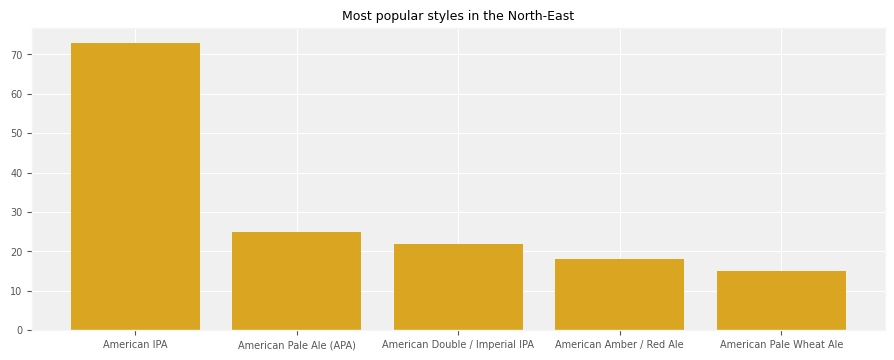

In [47]:
#North-East
s = NE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the North-East");

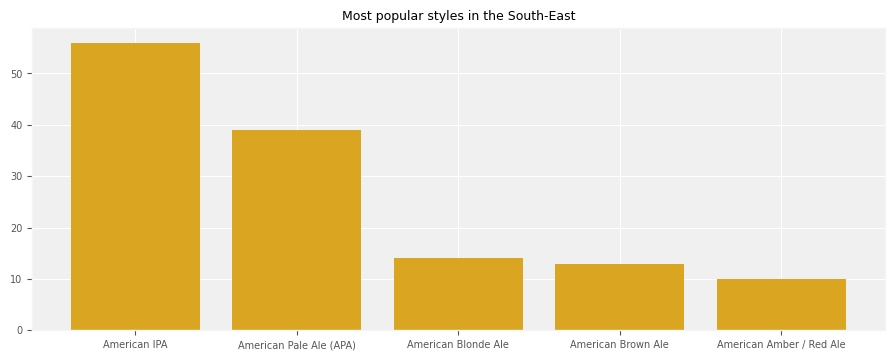

In [48]:
#South-East
s = SE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-East");

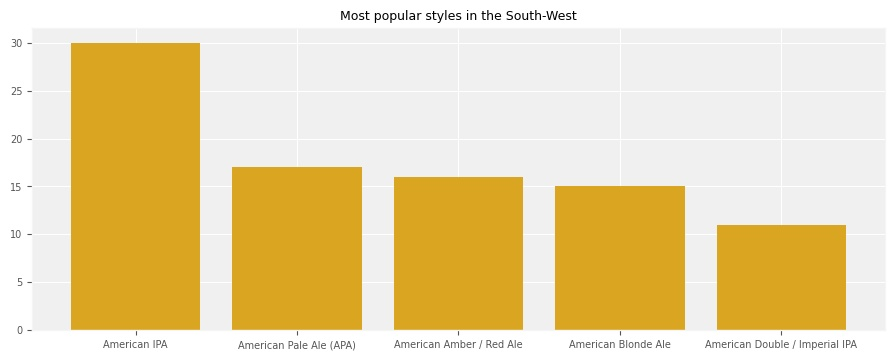

In [49]:
#South-West
s = SW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-West");

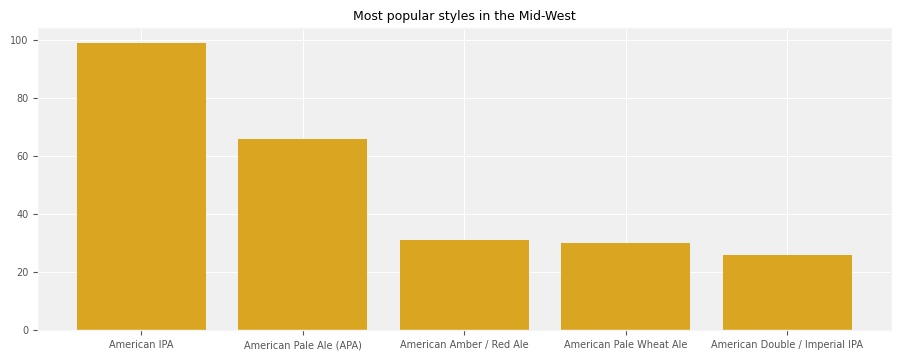

In [50]:
#Mid-West
s = MW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the Mid-West");

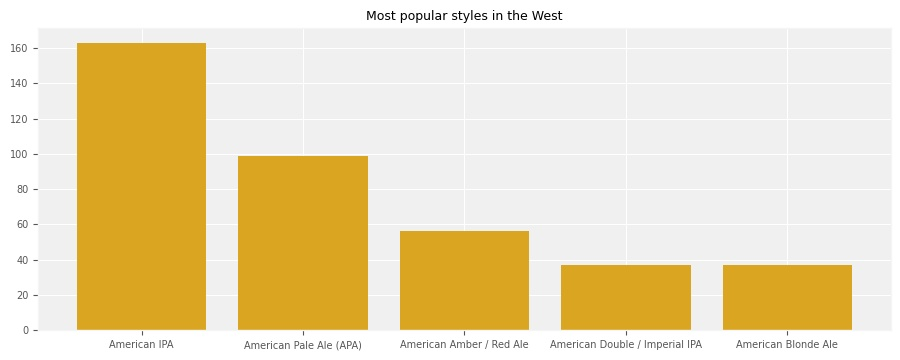

In [51]:
#West
s = W_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod');
plt.title("Most popular styles in the West");

It seems as though most regions have very similar taste with American IPA beeing most popular everywhere.

## Clustering

We use hierarchical clustering to identify and group similar beers together, so that we may later use these clusters for our recommendation function. 

We chose to use a clustering approach for the reccomendation function because our data does not contain any individual user information, so there is no reliable way to use matrix factorization.

In [52]:
import Orange
import scipy.cluster.hierarchy as sch
import scipy
from sklearn.metrics import silhouette_score
from collections import defaultdict

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [53]:
#makes the matrix for the beers
def init_matrix(dataset):
    names = sorted(list(set(dataset["name"])))
    styles = sorted(list(set(dataset["style"])))
    breweryID = sorted(list(set(dataset["brewery_id"])))
    matrix = []
    for name in names:
        row = []
        ibu = np.mean(dataset["ibu"][dataset["name"]==name])
        abv = np.mean(dataset["abv"][dataset["name"]==name])
        if (np.isnan(ibu)):  #uncomment these lines for -1 instead of NaN for ibu and abv
            row.append(np.nan)
        else:
            row.append(ibu)
        if (np.isnan(abv)):
            row.append(np.nan)
        else:
            row.append(abv)
        style = [x for x in sorted(list(set(dataset["style"][dataset["name"]==name])))][0]
        for s in styles:
            if style==s:
                row.append(1)
            else:
                row.append(0)
        bid = [x for x in sorted(list(set(dataset["brewery_id"][dataset["name"]==name])))][0]
        for b in breweryID:
            if bid==b:
                row.append(1)
            else:
                row.append(0)
        matrix.append(row)
    return matrix, names

def draw_clusters(matrix, dataset, method, metric, t):
    L = sch.linkage(np.array(matrix), method=method, metric=metric)
    predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
    classes     = np.array(matrix).ravel()
    return predictions

def plot_clusters(matrix, dataset, method, metric, t):
    L = sch.linkage(np.array(matrix), method=method, metric=metric)
    plt.figure(figsize=(25, 6))
    names = sorted(list(set(dataset["name"])))
    labels = [name for name in names]
    D      = sch.dendrogram(L, labels=labels, leaf_font_size=15);
    plt.plot([0, len(dataset)*10], [t, t], "k--")
    plt.ylabel("Razdalja")
    plt.show()

def score_clusters(matrix, predictions, metric): 
    score = silhouette_score(matrix, predictions, metric=metric)
    #score = calinski_harabasz_score(matrix,predictions)
    #score = davies_bouldin_score(matrix,predictions)
    return score

In [54]:
def getState(state):
    bid = dfBrewers["brewery_id"][dfBrewers["state"]==state]
    return dfBeers[dfBeers["brewery_id"].isin(bid)]

In [55]:
#get clusters as dictionary
def get_separate_clusters(linkage, names):
    groups_by_names = defaultdict(list)
    for group, name in zip(linkage, names):
        groups_by_names[group].append(name)
    return groups_by_names

In [56]:
#get best t metric for cutting the cluster
def get_t_cut(matrix, dataset, method, metric):
    scores=[]
    for t in np.linspace(0.5,0.95,num=10):
        predictions = draw_clusters(matrix, dataset, method, metric, t)
        score = score_clusters(matrix, predictions, metric)
        scores.append((t,score))
    return max(scores,key=lambda item:item[1])[0]
        

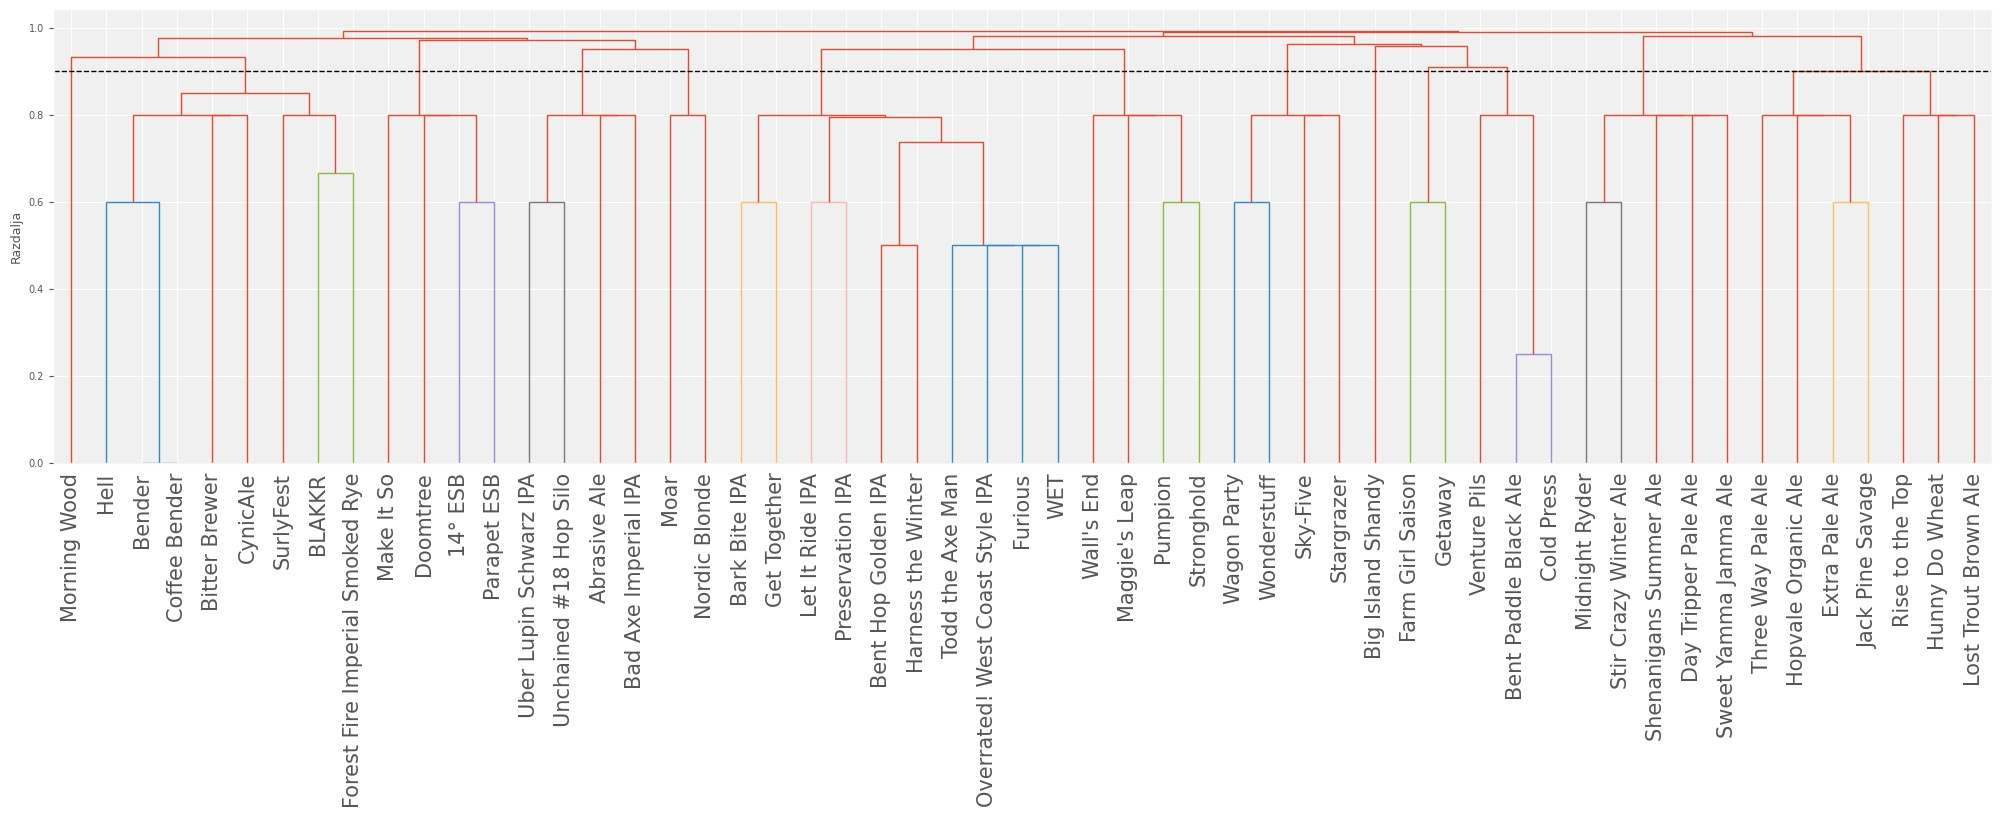

In [57]:
#State clusters example
state = getState("MN")
clusters, names = init_matrix(state)
optimal_t = get_t_cut(clusters, state, "weighted", "jaccard")
linkage = draw_clusters(clusters, state, "weighted", "jaccard", optimal_t)
plot_clusters(clusters, state, "weighted", "jaccard", optimal_t)

In [58]:
score_clusters(clusters, linkage, "jaccard")

0.21983070129404345

In [59]:
data_matrix, beer_names = init_matrix(dfBeers)

In [60]:
groups_by_names = get_separate_clusters(linkage, names)
groups_by_names

defaultdict(list,
            {3: ['14° ESB', 'Doomtree', 'Make It So', 'Parapet ESB'],
             4: ['Abrasive Ale',
              'Bad Axe Imperial IPA',
              'Uber Lupin Schwarz IPA',
              'Unchained #18 Hop Silo'],
             1: ['BLAKKR',
              'Bender',
              'Bitter Brewer',
              'Coffee Bender',
              'CynicAle',
              'Forest Fire Imperial Smoked Rye',
              'Hell',
              'SurlyFest'],
             6: ['Bark Bite IPA',
              'Bent Hop Golden IPA',
              'Furious',
              'Get Together',
              'Harness the Winter',
              'Let It Ride IPA',
              'Overrated! West Coast Style IPA',
              'Preservation IPA',
              'Todd the Axe Man',
              'WET'],
             10: ['Bent Paddle Black Ale', 'Cold Press', 'Venture Pils'],
             11: ['Big Island Shandy'],
             12: ['Day Tripper Pale Ale',
              'Midnight Ryder',


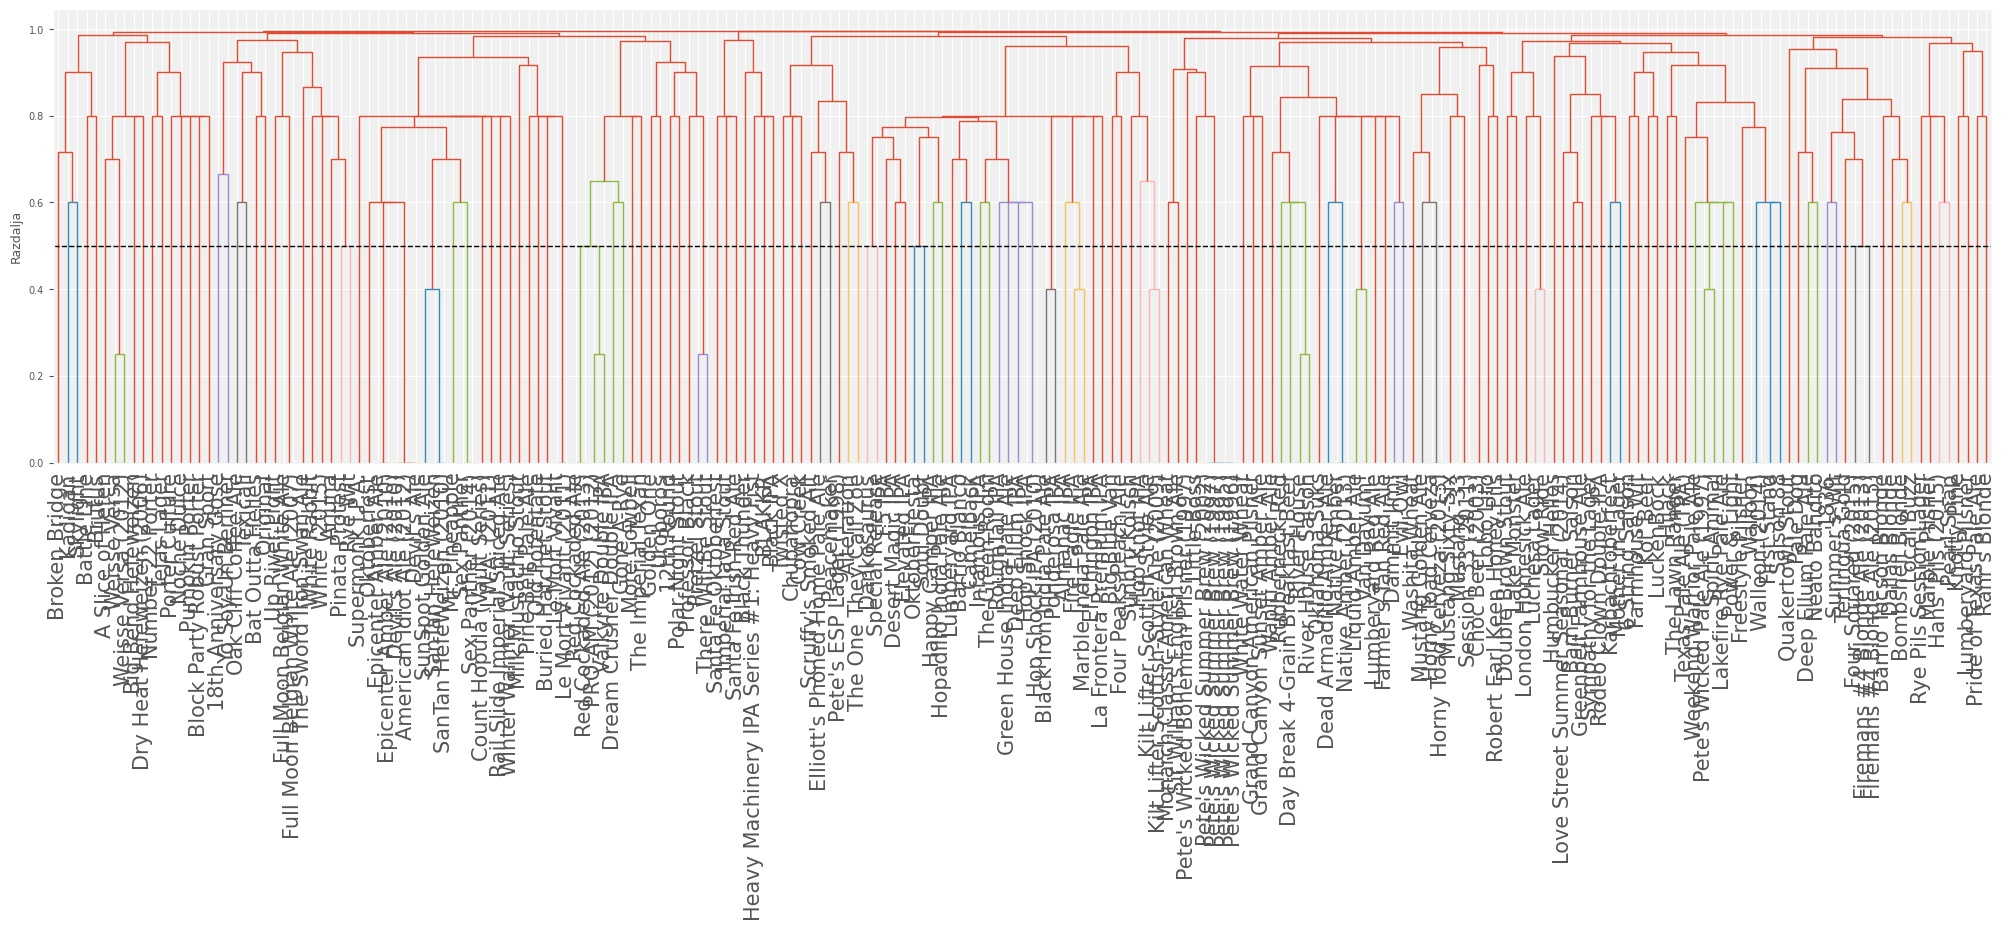

In [61]:
# South-West region clusters example
clusters, names = init_matrix(SW_Beers)
optimal_t = get_t_cut(clusters, SW_Beers, "weighted", "jaccard");
linkage = draw_clusters(clusters, SW_Beers, "weighted", "jaccard", optimal_t)
plot_clusters(clusters, SW_Beers, "weighted", "jaccard", optimal_t)

In [62]:
groups_by_names = get_separate_clusters(linkage, names)

# Recommendation function

For our recommendation function we will first create 2 clusterings for the whole beers dataset. First one using the optimal calculated t metric for cutting, and the second with the optimal metric decreased by 0.2 points. The second is mainly used in cases where the first's derived groups are too big and we need to branch out more to get a better recommendation. 

In [63]:
#Optimal t clustering
clusters, names = init_matrix(dfBeers)
optimal_t = get_t_cut(clusters, dfBeers, "weighted", "jaccard");
linkage = draw_clusters(clusters, dfBeers, "weighted", "jaccard", optimal_t)

In [64]:
first_grouping = get_separate_clusters(linkage, names)
#first_grouping

In [65]:
print("ID", end=": ")
print("Length")
counter=0
for i in first_grouping:
    if counter < 30:
        print(i, end=": ")
        print(len(first_grouping[i]))
        counter += 1

ID: Length
48: 22
64: 405
73: 53
1: 33
15: 102
70: 10
41: 14
71: 256
34: 11
59: 14
52: 57
68: 8
38: 93
49: 33
54: 99
29: 129
65: 18
61: 61
3: 10
58: 38
63: 20
53: 18
2: 33
45: 35
8: 27
40: 32
20: 20
5: 7
16: 43
24: 13


Above we have a sample of our clusters obtained using the optimal cutting length. As we can see, most clusters are of reasonable length, but we have some clusters with more than 400, 200 and 100 that are a bit too big to get recommendations from. This is why we employ the second clustering method for those.

In [66]:
#Secondary clustering
secondary_t = optimal_t
if secondary_t > 0.2:
    secondary_t -= 0.2
linkage = draw_clusters(clusters, dfBeers, "weighted", "jaccard", secondary_t)

In [67]:
second_grouping = get_separate_clusters(linkage, names)

In [68]:
numberOfOnes = 0
for i in second_grouping:
    if len(second_grouping[i]) == 1:
        numberOfOnes += 1
print("Number of lone clusters: ", end="")
print(numberOfOnes)

Number of lone clusters: 314


The problem with the second clustering approach, is that we get a lot of **lone clusters**, that is, clusters of length 1. This is a problem because we can not reccomend a beer from the same cluster in those situations.

Beacuse we use the secondary clustering only in situations where the first clustering's groups are too big, we must assess how often those big clusters branch out into lone clusters. We will look at the 5 biggest clusters in our analysis.

In [69]:
#checking how much of all single clustered beers in the secong grouping belong to the large clusters in the first grouping
#clusters 64(405), 71(256), 29(129), 15(102), 54(99), 38(93)

#Only those of 64(405)
howMuch = 0
for i in second_grouping:
    if len(second_grouping[i]) == 1:
        if second_grouping[i][0] in first_grouping[64]:
            howMuch += 1
print(howMuch) # 6

#Only those of 64(405) and 71(256)
howMuch = 0
for i in second_grouping:
    if len(second_grouping[i]) == 1:
        if second_grouping[i][0] in first_grouping[64] or second_grouping[i][0] in first_grouping[71]:
            howMuch += 1
print(howMuch) # 16

#All 5 except 54(99) and 38(93)
howMuch = 0
for i in second_grouping:
    if len(second_grouping[i]) == 1:
        if (second_grouping[i][0] in first_grouping[64] or second_grouping[i][0] in first_grouping[71] or
           second_grouping[i][0] in first_grouping[29] or second_grouping[i][0] in first_grouping[15]):
            howMuch += 1
print(howMuch) # 27

#All 5
howMuch = 0
for i in second_grouping:
    if len(second_grouping[i]) == 1:
        if (second_grouping[i][0] in first_grouping[64] or second_grouping[i][0] in first_grouping[71] or
           second_grouping[i][0] in first_grouping[29] or second_grouping[i][0] in first_grouping[15] or
           second_grouping[i][0] in first_grouping[54] or second_grouping[i][0] in first_grouping[38]):
            howMuch += 1
print(howMuch) # 39


6
16
27
39


We see that from all of these clusters combined, we get 39 lone clusters in the second grouping. A good middle ground seems to be dividing all large clusters above a length of 100, as we only get 27 lone clusters. This way our recommendation remains the most accurate.

In [70]:
#function to get cluster to which item belongs
def findCluster(item, grouping):
    for cluster in grouping:
        if item in grouping[cluster]:
            return cluster
    return None

In [71]:
#function to get dictionary of clusters for inputed beers(dict value is how many inputs share that same cluster)
def getClusterDict(likedBeers, grouping):
    clustersUsed = {}
    for beer in likedBeers:
        addTo = findCluster(beer, grouping)
        if addTo not in clustersUsed and len(grouping[addTo]) > 1:
            clustersUsed[addTo] = 1
        elif addTo in clustersUsed:
            clustersUsed[addTo] += 1
    return clustersUsed    

The function bellow accepts 5 input beers that the user already likes as guidance for what to reccomend. It locates the clusters those beers belong to in the first clustering. In the case that the cluster is smaller than 100, it finds the most commonly shared cluster among all inputs and recommends a set of beers from it. If the cluster is depleted of recommendation choices, we continue to the next most commonly shared cluster until we have a set of 5 beers to recommend to the user.

If the cluster is larger than 100, we repeat the whole process now using the secondary clustering groups. In the unlikely occasion where we run into a lone cluster, as a fallback, we recommend a set of beers using the first clustering's large cluster.

In [72]:
#main recommendation function
def recommendMe(likedBeers, likedBeerClusters):
    first_grouping_copy = {key: value[:] for key, value in first_grouping.items()}
    mostFrequent = max(likedBeerClusters.items(), key=operator.itemgetter(1))[0]
    cluster = first_grouping_copy[mostFrequent]
    toRecommend = []
    if len(cluster) < 100: #for all clusters with fewer than 100 elemnts pick beers at random from cluster
        while len(toRecommend) < 5:
            rand = random.choice(cluster)
            if rand not in likedBeers:
                toRecommend.append(rand)
                cluster.remove(rand)
            else:
                cluster.remove(rand)
            if len(cluster) <= 1: #if we exhaust all elemnts from one cluster, move on to the next
                likedBeerClusters.pop(mostFrequent,None)
                mostFrequent = max(likedBeerClusters.items(), key=operator.itemgetter(1))[0]
                cluster = first_grouping_copy[mostFrequent]
    else:
        secondClusters = getClusterDict(likedBeers,second_grouping)
        
        #check if second clustering has enough recommendations
        numOfRecs = 0;
        for i in secondClusters:
            numOfRecs += secondClusters[i]
        
        if numOfRecs >= 10:
            second_grouping_copy = {key: value[:] for key, value in second_grouping.items()}
            mostFrequent = max(secondClusters.items(), key=operator.itemgetter(1))[0]
            cluster = second_grouping_copy[mostFrequent]
            while len(toRecommend) < 5:
                rand = random.choice(cluster)
                if rand not in likedBeers:
                    toRecommend.append(rand)
                    cluster.remove(rand)
                else:
                    cluster.remove(rand)
                if len(cluster) <= 1: #if we exhaust all elemnts from one cluster, move on to the next
                    secondClusters.pop(mostFrequent,None)
                    mostFrequent = max(secondClusters.items(), key=operator.itemgetter(1))[0]
                    cluster = second_grouping_copy[mostFrequent]
        else:
            while len(toRecommend) < 5:
                rand = random.choice(cluster)
                if rand not in likedBeers:
                    toRecommend.append(rand)
                    cluster.remove(rand)
                else:
                    cluster.remove(rand)
                if len(cluster) <= 1: #if we exhaust all elemnts from one cluster, move on to the next
                    likedBeerClusters.pop(mostFrequent,None)
                    mostFrequent = max(likedBeerClusters.items(), key=operator.itemgetter(1))[0]
                    cluster = first_grouping_copy[mostFrequent]
    return toRecommend

Bellow is an example of how the function works

In [73]:
beerArr = ['Monarch Classic American Wheat', 'Pace Setter Belgian Style Wit', 'Pit Stop Chocolate Porter', 'Tripel Deke', 'Siamese twin']

In [74]:
cl = getClusterDict(beerArr, first_grouping)
cl

{72: 3, 4: 1, 10: 1}

In [75]:
tryBeers = recommendMe(beerArr,cl)
tryBeers

['Kilt Lifter Scottish-Style Ale (2009)',
 'Kilt Lifter Scottish-Style Ale',
 'Totally Radler',
 'Pumpkin Porter',
 'Lemon Shandy Tripel']

In [76]:
tryCl = getClusterDict(tryBeers, first_grouping)
tryCl

{72: 4, 4: 1}

## GUI Implementation

In [77]:
beerNames = [name for name in dfBeers["name"]]
beerNamesHint = {name: len(name) for name in beerNames}
beerNamesHint = sorted(beerNamesHint, key=beerNamesHint.get)[30:35]
recommendBeerNamesString = "Hint:  "
for beer in beerNamesHint:
    recommendBeerNamesString+=beer+",  "
recommendBeerNamesString = recommendBeerNamesString[:-3]
def isBeerValid(beer):
    return beer in beerNames

In [78]:
def createRecommendedBeerList(line):
    print("Starting..")
    if (line == ""):
        return ["Please enter at least 5 beer names!"]
    
    beers = []
    for beer in line.split(","):
        if (len(beer.strip())>0):
            if (isBeerValid(beer.strip())):
                beers.append(beer.strip())

    if (len(beers)<5):
        if (len(line.split(", "))<5):
            return ["Please enter at least 5 beer names!"]
        return ["Invalid beer name!"]
    clusterDict = getClusterDict(beers, first_grouping)
    tryBeers = recommendMe(beers,clusterDict)
    return tryBeers

In [79]:
from PyQt5 import QtWidgets
from PyQt5.QtWidgets import QApplication, QMainWindow
import sys


def window():
    app = QApplication(sys.argv)
    win = QMainWindow()
    win.setGeometry(200, 150, 1200, 800)
    win.setWindowTitle('Canned beer recommendation system')
    win.setStyleSheet("background-color: qlineargradient(spread:pad, x1:0, y1:0, x2:1, y2:1, stop:0 rgba(0, 0, 255, 255), stop:1 rgba(157, 255, 255, 255));")
    
    label = QtWidgets.QLabel(win)
    label.setText("Recommendation system for canned beers")
    label.setGeometry(0, 0, 700, 150)
    label.move(250, 150)
    label.setStyleSheet("background: transparent; font-size: 36px; color: white;")

    inputLabel = QtWidgets.QLabel(win)
    inputLabel.setText("Input some of your favorite beers: ")
    inputLabel.setStyleSheet("background: transparent; color: white;")
    inputLabel.setGeometry(0, 0, 250, 50)
    inputLabel.move(100, 500)

    line = QtWidgets.QLineEdit(win)
    line.setStyleSheet("background: transparent; color: white;")
    line.setGeometry(0, 0, 200, 30)
    line.move(400, 510)
    
    b1 = QtWidgets.QPushButton(win)
    b1.setStyleSheet("background: transparent; color: white;")
    b1.setText("Recommend")
    b1.setGeometry(0, 0, 200, 30)
    b1.move(500, 350)

    resultLabel = QtWidgets.QLabel(win)
    resultLabel.setStyleSheet("background: transparent; color: white;")
    resultLabel.setGeometry(0, 0, 300, 250)
    resultLabel.move(900, 350)
    
    recommendLabel = QtWidgets.QLabel(win)
    recommendLabel.setStyleSheet("background: transparent; color: white;")
    recommendLabel.setGeometry(0, 0, 300, 50)
    recommendLabel.move(150, 600)
    
    def clicked():
        resultLabel.setText("")
        recommendLabel.setText("")
        results = createRecommendedBeerList(line.text())
        if (len(results)==1):
            recommendLabel.setText(recommendBeerNamesString)
        s = "Results:\n\n"
        for i in range(0, len(results)):
            s+="- "+results[i]+"\n\n"
        resultLabel.setText(s)
    
    b1.clicked.connect(clicked)
    
    win.show()
    sys.exit(app.exec_())    


In [80]:
window()

SystemExit: 0